# 영화 추천 시스템 만들기

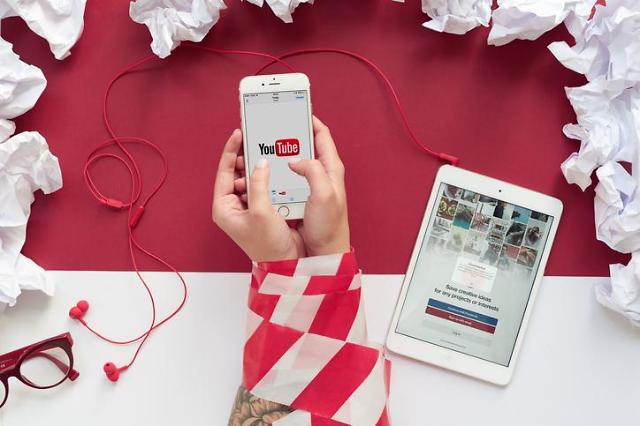

나는 유튜브를 많이 보는 편인데 유튜브가 추천해주는 영상들을 볼때마다 깜짝깜짝 놀란다.

 마치 내가 무엇을 좋아하는지 내 생각을 다 아는 것 같은 느낌을 받는다. 

 뿐만 아니라 쿠팡이나 네이버에서 쇼핑을 하다보면 클릭 하지 않을 수 없게 자꾸 추천을 해준다.
 
   이런 서비스들이 너무 정교하고 신기해서 평소에 관심이 많았는데 이번 기회에 영화 데이터를 가지고 추천 시스템을 만들어 보려고 한다.

## Goal : 
1) 어떤 영화가 인기있고 수익을 많이 내는지 알아보고 

2) 사람들에게 알맞는 영화를 추천해 소비자의 만족도를 높이고 나아가 더 많은 수익을 얻는 방법을 찾아보자.

다음과 같은 순서로 구성되어 있다. 

1. Exploration

2. Recommandation System

3. Conclusion

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Exploration

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
saving = False

In [83]:
movie = pd.read_csv('/content/drive/MyDrive/Kaggle/Movie Recommandation/tmdb_5000_movies.csv')
credit = pd.read_csv('/content/drive/MyDrive/Kaggle/Movie Recommandation/tmdb_5000_credits.csv')
rating_ = pd.read_csv('/content/drive/MyDrive/Kaggle/Movie Recommandation/ratings_small.csv')
movielen = pd.read_csv('/content/drive/MyDrive/Kaggle/movielen.csv')

데이터 출처 
: 
 https://www.kaggle.com/tmdb/tmdb-movie-metadata

https://www.kaggle.com/grouplens/movielens-20m-dataset


In [84]:
movie.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [85]:
credit.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [86]:
rating_.head(2)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179


- timestamp :  어느 시점에 데이터가 존재했다는 사실을 증명하기 위하여 특정 위치에 표시하는 시각.

In [87]:
rating_movieId = rating_['rating'].groupby(rating_['movieId']).sum()
rating_movieId.value_counts()

4.0      738
3.0      580
3.5      446
5.0      417
2.5      291
        ... 
222.5      1
163.5      1
334.5      1
790.0      1
366.5      1
Name: rating, Length: 661, dtype: int64

In [88]:
movielen.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


데이터에 대한 설명은 참조 링크에 들어가면 자세히 쓰여져 있다. 
- genres : 영화 장르
- keywords : 영화의 키워드
- original_language : 영화 언어
- title : 제목
- revenue : 수입
- vote_average : 평점 평균
- vote_count = 평점 카운트
- populariy : 인기도
- overview : 개요 설명

등의 컬럼을 사용할 예정이다. homepage, status 같은 feature들이 중요할 수도 있지만 여기서는 사용하지 않을 것이다.

In [89]:
credit.columns = ['id', 'title', 'cast', 'crew']
data = movie.merge(credit, on='id')
data.rename(columns={'title_x' : 'title'}, inplace=True)
data.drop(['original_title', 'title_y','homepage', 'production_companies', 'status', 'tagline', 'cast', 'crew'], axis=1, inplace=True)
data.head(2)

,budget,genres,id,keywords,original_language,overview,popularity,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Pirates of the Caribbean: At World's End,6.9,4500


In [90]:
data.shape

(4803, 15)

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 15 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null int64
dtypes: float64(3), int64(4), object(8)
memory usage: 600.4+ KB


## 데이터 살펴보기
데이터들이 말하는 것이 무엇이며 어떤 데이터를 어떻게 사용하지 찾아보자.

In [92]:
def group_indices(series,index="id"):
    d={}
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:
            d.setdefault(x[index],[])
            d[x[index]].append(i)
    return d

def get_groups(series,index="name"):
    s=set()
    for i in range(series.size):
        l=eval(series.iloc[i])
        for x in l:s.add(x[index])
    return list(s)

def multi_count(series,index="id"):
    return {k:len(v) for (k,v) in group_indices(series,index).items()}

def expand_multi_feature(df,column,index="id"):
    groups=group_indices(df[column],index=index)
    result=pd.DataFrame()
    for name,indices in groups.items():
        rows=df.iloc[indices].copy()
        rows[column]=name
        result=result.append(rows)
    return result

def multi_groupby(df,column,index="id"):
    return expand_multi_feature(df,column,index).groupby(column)

### 장르별로 보기
다른 feature 들은 연속적이라 카테고리컬 데이터인 '장르'를 기준으로 데이터를 살펴보자.

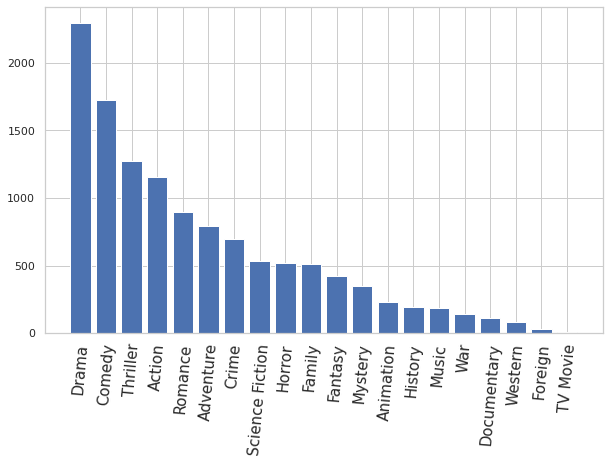

In [93]:
#장르별 영화수
sns.set(style="whitegrid")
count=multi_count(data.genres,"name")
count=sorted(count.items(),key=lambda x:x[1],reverse=True)
count=dict(count[:30])
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(count.keys(),count.values(),align="center")
plt.show()

Text(0, 0.5, 'vote_count')

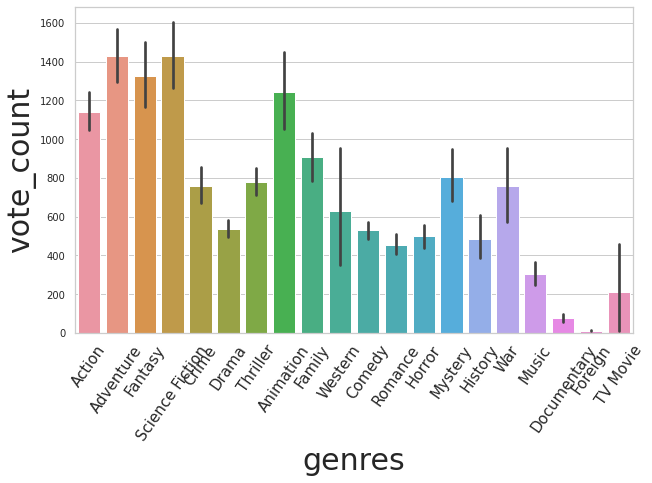

In [94]:
#장르별 평점 개수
sns.set(style="whitegrid")
data=data.replace(0,np.nan).copy()
f,ax=plt.subplots(figsize=(10, 6))
sns.barplot(data=expand_multi_feature(data,'genres',"name"),x='genres',y='vote_count')
plt.yticks(fontsize=10)
plt.xticks(rotation=55,fontsize=15)
plt.xlabel('genres',fontsize=30)
plt.ylabel('vote_count',fontsize=30)

장르별 영화의 평점 개수를 살펴보면 Adventure, Fantasy, Animation의 평점수가 가장 많았고 Documentary, Foreign 장르의 영화는 평점의 개수가 적었습니다. 

Text(0, 0.5, 'popularity')

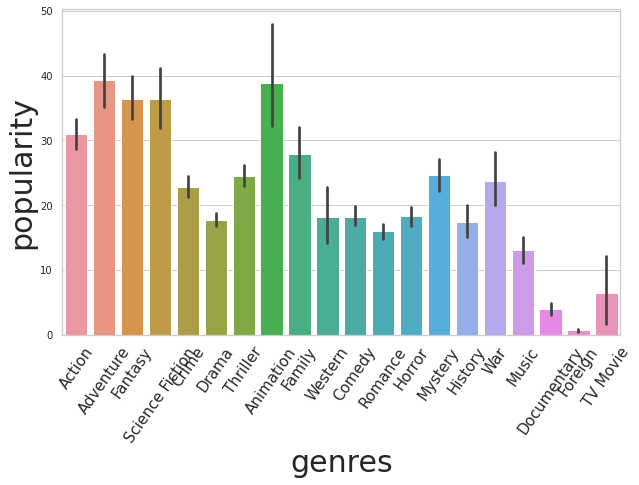

In [95]:
#장르별 인기도
sns.set(style="whitegrid")
data=data.replace(0,np.nan).copy()
f,ax=plt.subplots(figsize=(10, 6))
sns.barplot(data=expand_multi_feature(data,'genres',"name"),x='genres',y='popularity')
plt.yticks(fontsize=10)
plt.xticks(rotation=55,fontsize=15)
plt.xlabel('genres',fontsize=30)
plt.ylabel('popularity',fontsize=30)

Adventure, Animation 장르가 가장 인기가 높았고 Documentary, Foreign 장르의 영화가 인기도 낮았습니다.

하지만 인기도가 어떤 기준으로 측정되어 있는지 데이터의 설명이 없어 조금 모호하다 생각을 했습니다.

### 돈의 관점으로 보기

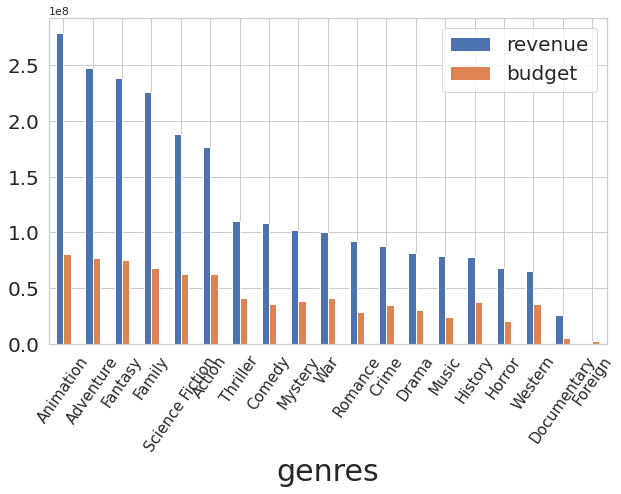

In [96]:
#예산과 수익
sns.set(style="whitegrid")
data1 = data.replace(0,np.nan).copy()
f,ax=plt.subplots(figsize=(10, 6))
multi_groupby(data1.dropna(subset=["revenue","budget"]),'genres',"name")["revenue","budget"].mean().sort_values(["revenue","budget"],ascending=False).plot(kind="bar",ax=ax)
plt.yticks(fontsize=20)
plt.xticks(rotation=55,fontsize=15)
plt.xlabel('genres',fontsize=30)
plt.legend(prop={'size': 20})

수익을 보면 Animation의 수익이 가장 좋았고 Adventure, Fantasy순으로 높았다. 반면 Dacumentary와 Foreign 영화는 수익이 가장 낮았다. 

예산과 수익의 관계를 보면 일반적으로 높은 예산을 가진 영화들이 수익 또한 높은 것을 확인할 수 있다. 

### 국가별로 보기

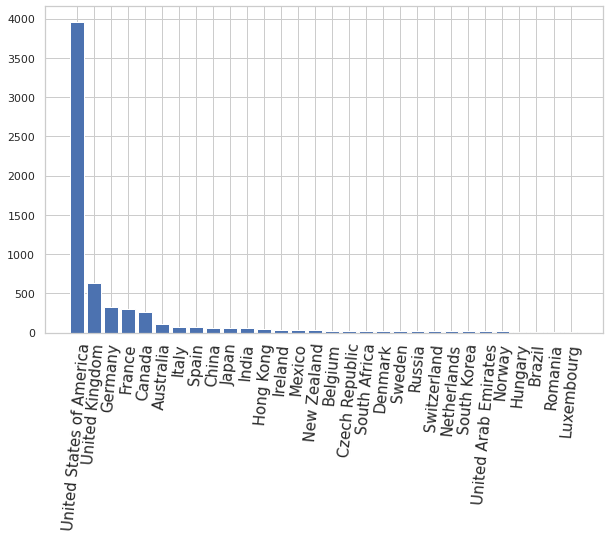

In [97]:
#국가별 영화수
sns.set(style="whitegrid")
count=multi_count(data.production_countries,"name")
count=sorted(count.items(),key=lambda x:x[1],reverse=True)
count=dict(count[:30])
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(count.keys(),count.values(),align="center")
plt.show()

미국이 압도적으로 많은 영화를 발표했다.

## feature간의 상관관계

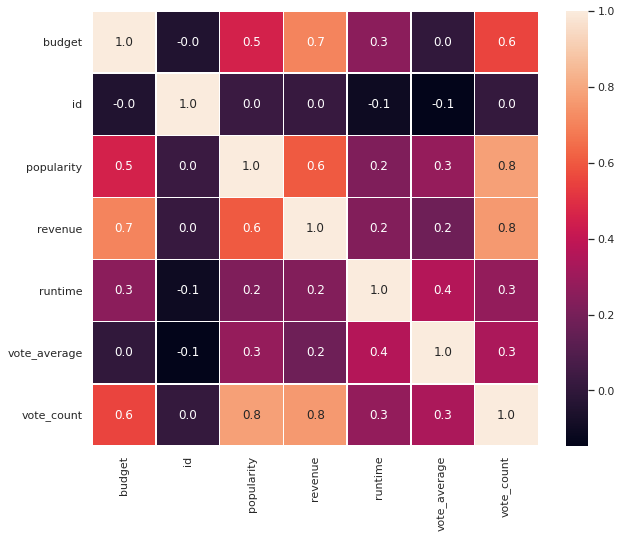

In [98]:
#corrleation map
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)
plt.show()

- budget과 revenue
- popularity와 vote_count
- revenue와 vote_count 

가 높은 상관관계를 지니는 것을 확인할 수 있다. (0.7이상)

직관적으로 생각해볼때 예산을 많이 들인 영화가 수익이 높고 인기가 많은 영화가 투표를 많이 받고 수입이 많은 영화가 투표를 많이 받는 것을 알 수 있다.

-> 사람들이 많이 본 영화(=투표숫자 많다)가 인기도가 높고 수익을 많이 얻는 것을 알 수 있다.

이 feature들에 대해 조금 더 살펴보자.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f365f1014e0>,
      dtype=object)

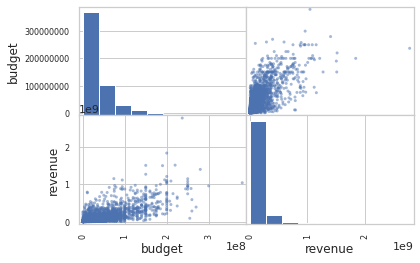

In [99]:
pd.plotting.scatter_matrix(data[['budget', 'revenue']])

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f365f110278>,
      dtype=object)

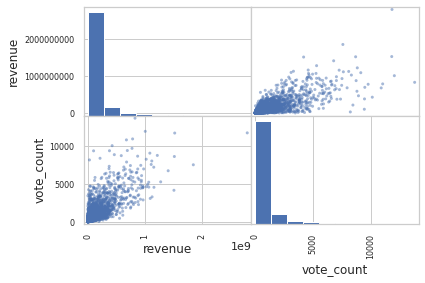

In [100]:
pd.plotting.scatter_matrix(data[['revenue', 'vote_count']])

대부분의 값들이 특정 구간에 몰려있다. 연속적인 데이터를 카테고리 데이터로 변환해서 살펴보자.

In [101]:
bins1 = np.linspace(data['revenue'].min(), data['revenue'].max(), 10)
data['revenue_bin'] = np.digitize(data['revenue'], bins1)
bins2 = np.linspace(data['vote_count'].min(), data['vote_count'].max(), 10)
data['vote_count_bin'] = np.digitize(data['vote_count'], bins2)
bins3 = np.linspace(data['popularity'].min(), data['popularity'].max(), 10)
data['popularity_bin'] = np.digitize(data['popularity'], bins3)

In [102]:
data['popularity_bin'].value_counts()
data['vote_count_bin'].value_counts()

1     4145
2      357
3      132
10      63
4       56
5       29
6       11
7        5
8        5
Name: vote_count_bin, dtype: int64

데이터가 특정 구간에 몰려있다. 즉, 인기있고 수익을 많이 낸 영화들은 소수이고 대부분의 영화들은 수익을 많이 올리지 못했고 사람들이 많이 보지 않았다.

- 각 feature가 의미하는 바가 완전히 달라 t-test를 사용하지 못한다.
- 주요 feature들간에 명확한 상관관계가 있어 chi-squar test가 의미없다.


살펴본 데이터에 의하면 충분한 상관관계가 있지만 굉장히 imbalance한 데이터셋여서 다른 feature를 고려해보자. 모든 영화들은 1점부터 5점까지 평점을 받고 그 평점은 관객이 그 영화가 얼마나 좋았는지를 나타내기 때문에 평점을 feature로 잡자.



In [103]:
bins4 = np.linspace(rating_['rating'].min(), rating_['rating'].max(), 5)
rating_['rating_bin'] = np.digitize(rating_['rating'], bins4)
rating_['rating_bin'].value_counts()

4    36473
3    30602
5    15095
2    11720
1     6114
Name: rating_bin, dtype: int64

3,4점이 가장 많았고 전체적으로 분포가 고르다. -> 적절한 feature라고 생각한다.

# 2. Recommendation Systmem

## 2-1. Demographic Filtering

아까 분포를 봤을 때 Adventure, Animation, Fantasy의 장르는 평점 개수가 많았고, 즉 본 사람 많았고 인기도 높았고 수익도 높았다. 반면 Documentary나 Foreign장르는 평점수도 적도 인기도 적고 수익도 적었다. 
- 그래서 많은 사람들이 좋아하는 영화는 또 다른 새로운 사람도 좋아할 것이 핵심 아이디어

Text(0, 0.5, 'Popular Movies')

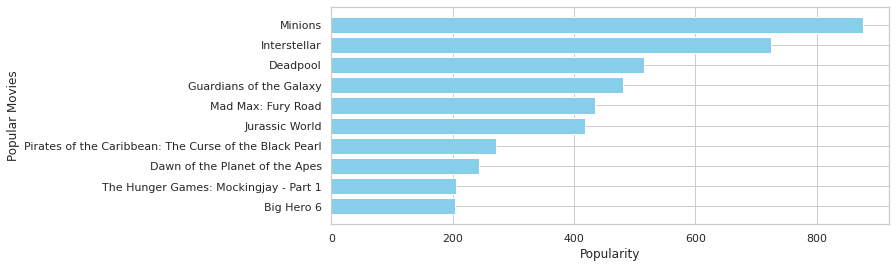

In [104]:
pop = data.sort_values('popularity', ascending=False)
plt.figure(figsize=(10,4))
plt.barh(pop['title'].head(10), pop['popularity'].head(10), align='center',color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Popularity')
plt.ylabel('Popular Movies')

Minions, Interstellar, Deadpool, Guardians of the Galaxy, Mad Max, Jurrassic World 등 개인적으로 아주 재밌게 본 영화들을 볼 수 있고 충분히 합리적인 추천이라고 생각이 된다.

하지만 인기도를 측정하는 정확한 기준에 대한 설명이 없어서 조금 모호하다. -> 평점


vote_average를 살펴볼 필요가 있다. 예를 들어 3명이 평가해 평점 8.5인 영화가 40명이 평가해 평점 7.5인 영화보다 낫다고 여기진다. 과연 타당한 결론일까? 그래서 IMDB's weight rating을 사용할 것이다. 

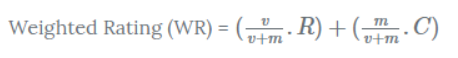

- v : 영화에 투표한 수
- m : 차트에 올라가기 위한 최소 투표수
- R : 평균 평점
- C : 전체에 대한 평균 평점

이미 v와 R을 알고 있으므로 m과 C를 찾자.




In [105]:
C = data['vote_average'].mean()
C

6.173143459915607

즉, 영화 평점 평균은 10점 만점에 6점정도가 된다. 다음은 최소 m을 찾아야 한다. 90%를 기준으로 잘라보자.

In [106]:
m = data['vote_count'].quantile(0.9)
m

1880.0

In [107]:
q_movie = data.copy().loc[data['vote_count'] >= m]
q_movie.shape

(475, 18)

475개의 영화가 조건을 만족한다. 이제 weighted_rating을 만족하는 함수를 만들어서 새로운 점수를 만들자. 

In [108]:
def weighted_rating(x,m=m, C=C):
  v = x['vote_count']
  R = x['vote_average']
  return (v/(v+m)*R) + (m/(m+v) *C) #WR 

In [109]:
# score 라는 새로운 feature를 만들어주자.
q_movie['score'] = q_movie.apply(weighted_rating, axis=1)

score를 측정해주는 함수를 만들었으니 score값으로 데이터를 정렬해보자.

In [110]:
q_movie = q_movie.sort_values('score', ascending=False)
q_movie[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205.0,8.5,8.066238
662,Fight Club,9413.0,8.3,7.945932
65,The Dark Knight,12002.0,8.2,7.925509
3232,Pulp Fiction,8428.0,8.3,7.912098
96,Inception,13752.0,8.1,7.868264
3337,The Godfather,5893.0,8.4,7.861406
95,Interstellar,10867.0,8.1,7.815816
809,Forrest Gump,7927.0,8.2,7.811452
329,The Lord of the Rings: The Return of the King,8064.0,8.1,7.735711
1990,The Empire Strikes Back,5879.0,8.2,7.708894


결과를 확인해보면 쇼생크탈출, 파이트클럽, 다크나이트, 인셉션 등 명작들이 높은 순위에 랭크된다. 즉, 많은 사람들이 좋아한 영화를 추천해줄 수 있다. 

위의 방법들은 단순히 많은 사람들이 좋아한 영화를 추천해주는 것이기 때문에 한계가 명확하다. 이번에는 조금 더 개인의 취향을 맞춘 추천을 해보자.

## 2-2. 콘텐츠 기반 필터링



이번에는 유사한 컨텐츠를 추천하는 시스템을 만들어보자. 즉, User A가 Movie A를 좋아한다면 movie A와 비슷한 movie C를 추천해주는 것이다. 
컨텐츠 유사도를 계산하기 위해서 overview feature를 활용해보자.


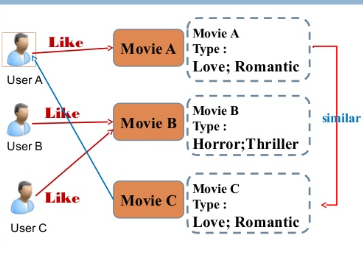

In [111]:
data['overview'].head()

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

글자들이 쭉 나열되어 있으니까 이것을 벡터로 변환을 해서 사용하자. TF-IDF(Term Frequency-Inverse Document Frequency)를 사용할 것이다. TD-IDF는 overview 단어들을 행렬로 표현해준다. 

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

data['overview'] = data['overview'].fillna('') # 결측치는 비우기

tfidf_matrix = tfidf.fit_transform(data['overview'])
tfidf_matrix.shape

(4803, 20978)

20000개 이상의 다른 단어들이 4803개의 영화를 설명하는 것을 확인할 수 있다. 

이 행렬을 가지고 유사도 점수를 계산해보자. 

여기에서는 벡터 내적의 코사인을 이용하자.벡터의 내적에서 코사인은 두 벡터의 방향의 유사도를 나타내준다. 

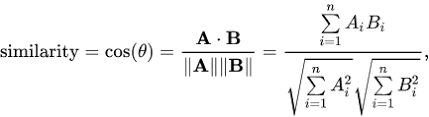

In [113]:
from sklearn.metrics.pairwise import linear_kernel
#코사인 유사도 계산
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

이제 영화의 제목을 입력하면 유사한 영화를 추천해주는 함수를 만들어보자.

In [114]:
indices = pd.Series(data.index, index=data['title']).drop_duplicates()

다음과 같은 순서로 만들자.
- 영화의 제목으로 인덱스를 잡고
- 코사인 유사도를 리스트로 정렬하고
- 리스트의 10개 원소를 가져오고
- 그중 탑 원소들을 리턴하자.

In [115]:
def get_recommendations(title, cosine_sim=cosine_sim):
  # 영화 제목으로 인덱스를 잡는다.
  idx = indices[title]
  #코사인 유사도를 리스트로 받는다.
  sim_scores = list(enumerate(cosine_sim[idx]))
  #코사인 유사도를 정렬한다.
  sim_scores = sorted(sim_scores, key=lambda x:x[1], reverse=True)
  #유사도 1~10등까지 선택한다.
  sim_scores = sim_scores[1:11]
  #그 때의 인덱스를 가져온다.
  movie_indices = [i[0] for i in sim_scores]

  return data['title'].iloc[movie_indices]

컨텐츠 기반의 추천 시스템을 만들어봤다. 이제 잘 작동하는지 확인해보자.

In [116]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [117]:
get_recommendations('The Avengers')

7               Avengers: Age of Ultron
3144                            Plastic
1715                            Timecop
4124                 This Thing of Ours
3311              Thank You for Smoking
3033                      The Corruptor
588     Wall Street: Money Never Sleeps
2136         Team America: World Police
1468                       The Fountain
1286                        Snowpiercer
Name: title, dtype: object

다크나이트 입력할때  배트맨 시리즈를 추천해주고 어벤져스를 입력할때 어벤져스 시리즈를 추천해줬다.

어벤져스와 유사하다고 추천한 영화들은 다소 거리가 있다고 생각이 된다.

##3. 잠재요인 협업 필터링

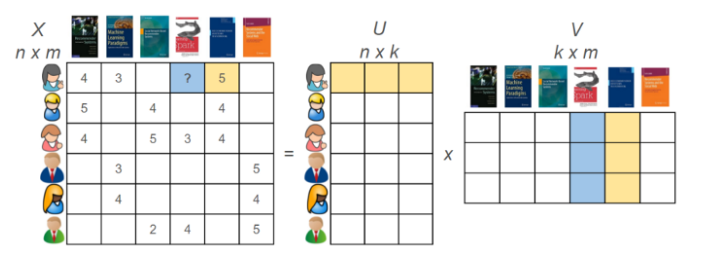

넷플릭스가 사용한 후 많이 사용되고 있는 방법으로 다차원 행렬을 분해하는 과정에서 잠재 요인(Latent Factor)를 뽑아내는 방법이다. 




- rating_ 데이터 : 사용자 - 영화 평점 데이터
- movielen 데이터 : 영화 정보 데이터


먼저 사용자 - 영화 평점 데이터를 pivot table 형식으로 바꿔준다.
즉, '사용자 별 각 영화 평점 방식'으로 바꿔는 것이다. 그러면 N명의 사용자가 있고 M의 영화가 있으면 NxM크기의 행렬이 만들어 진다.

In [118]:
movie_df = rating_.pivot(index='userId', columns='movieId', values='rating').fillna(0)
movie_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,...,155820,156025,156387,156607,156609,156726,157200,157296,157407,157667,158238,158314,158528,158956,159093,159462,159690,159755,159858,159972,160080,160271,160438,160440,160563,160565,160567,160590,160656,160718,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
pip install pandas==0.25.3

그 다음 각 N명의 사용자들이 매긴 각각의 평균 평점을 구해보자.

그리고 그 값을 사용자-영화 평점 값에서 빼자.

In [120]:
#numpy matrix로 만들기
matrix1 = movie_df.as_matrix()
#사용자의 평균 평점
user_rating_mean = np.mean(matrix1, axis=1)
#사용자-영화에 대해 사용자 평균 평점을 뺀 것
matrix_user_mean = matrix1 - user_rating_mean.reshape(-1,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


원래 0~5까지 존재하던 평점 데이터 분포가 각 사용자의 평균 평점을 빼니까 -0.029 이런식으로 변경된다.

In [121]:
pd.DataFrame(matrix_user_mean, columns=movie_df.columns).head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,...,155820,156025,156387,156607,156609,156726,157200,157296,157407,157667,158238,158314,158528,158956,159093,159462,159690,159755,159858,159972,160080,160271,160438,160440,160563,160565,160567,160590,160656,160718,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,2.494375,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,...,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625,-0.005625
1,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,3.970770,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,4.970770,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,4.970770,-0.029230,-0.029230,...,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230,-0.029230
2,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,...,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075,-0.020075
3,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,3.902162,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,4.902162,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,...,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838,-0.097838
4,-0.043128,-0.043128,3.956872,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,-0.043128,3.956872

이제 SVD를 적용해보자. 특이값 분해라고 불리는 SVD는 m x n 크기의 데이터 행렬 A를 다음과 같이 분리하는 것을 말한다.

행렬 U와 V에 속한 열벡터는 singular vector로 서로 직교하는 성질이 있다.
저렇게 특이값으로 쪼개진 데이터 U, sigma, Vt를 각각 행렬곱을 하면 원래 행렬 A로 되돌릴 수 있다.



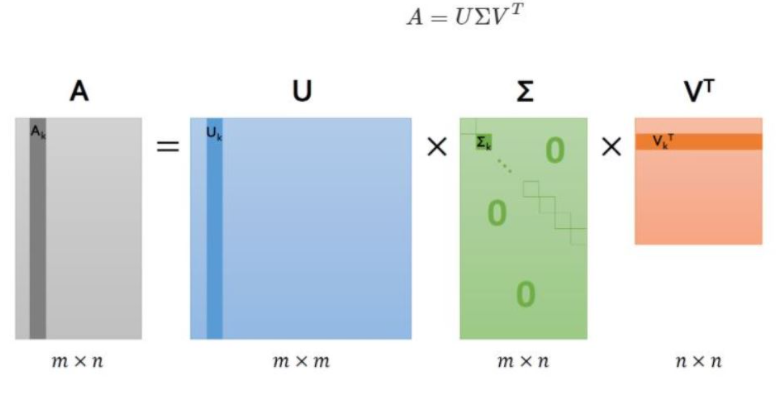

In [122]:
from scipy.sparse.linalg import svds
#U : 행렬, sigma 
U, sigma, Vt = svds(matrix_user_mean, k=12)

print(U.shape)
print(sigma.shape)
print(Vt.shape)

(671, 12)
(12,)
(12, 9066)


In [123]:
sigma = np.diag(sigma)
sigma[0]

array([105.72437051,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

1. 원본 유저 - 영화 평점 행렬이 있었음
2. 이를 유저의 평균점수를 빼서 matrix_user_mean 행렬을 만듬
3. 2번 값을 SVD를 적용해 U, Sigma, Vt행렬을 구함
4. Sigma 행렬은 0이 포함되지 않은 값으로만 구성

In [124]:
#U, sigma, Vt, 의 내적을 하면 다시 원본 행렬로 복원이 된다.
# 거기에 사용자 평균 rating을 더해준다.
svd_predict = np.dot(np.dot(U, sigma), Vt) + user_rating_mean.reshape(-1,1)

In [125]:
svd_predict = pd.DataFrame(svd_predict, columns=movie_df.columns)
svd_predict.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,...,155820,156025,156387,156607,156609,156726,157200,157296,157407,157667,158238,158314,158528,158956,159093,159462,159690,159755,159858,159972,160080,160271,160438,160440,160563,160565,160567,160590,160656,160718,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.079686,0.021779,-0.013837,-0.005870,-0.028877,0.032371,0.000715,-0.004428,-0.005219,0.038195,0.016529,0.005170,0.001626,-0.005785,0.012191,0.035154,-0.003522,-0.014232,0.003249,-0.000856,0.051961,0.003574,0.000443,0.026025,0.003044,0.004454,-0.008929,0.009934,0.028403,-0.006952,0.009034,0.020068,0.035193,0.002793,-0.025641,-0.003540,-0.002402,0.024249,-0.003985,-0.016380,...,-0.003824,-0.005378,-0.003989,-0.005605,-0.001955,0.013038,-0.003296,-0.002892,-0.003944,-0.003296,0.019296,-0.005399,-0.001182,-0.006048,-0.004537,0.010478,-0.002767,-0.003824,0.017265,-0.004352,-0.003824,-0.002239,-0.006509,-0.003944,-0.004459,-0.002767,-0.000654,-0.005847,-0.004101,-0.003989,-0.004324,-0.004352,0.010478,-0.004256,-0.003944,-0.005674,0.018157,-0.005575,-0.005297,-0.003766
1,1.428452,1.608841,0.529476,0.168278,0.520809,1.107473,0.529719,0.089376,0.296270,1.970031,1.334344,0.118010,0.074826,0.268758,0.120281,0.537446,1.121948,0.172813,1.024733,0.156633,1.303286,0.764510,0.437088,0.133792,1.007832,0.040924,0.173616,0.192708,0.375512,0.142522,0.731898,1.663473,2.026017,0.223532,0.963040,0.015549,-0.003812,1.865005,0.084174,0.178060,...,-0.004103,0.003787,0.021431,-0.002261,-0.003485,0.024201,-0.005930,-0.011921,-0.007644,-0.005930,0.014927,-0.004646,-0.013242,-0.003568,-0.004771,0.020680,-0.007758,-0.004103,0.009578,-0.002275,-0.004103,-0.009586,-0.022052,-0.007644,-0.020560,-0.007758,-0.015069,0.011748,0.018696,0.021431,0.013227,-0.002275,0.020680,-0.005245,-0.007644,-0.021019,0.031243,-0.000957,-0.000753,0.026901
2,0.977246,0.396971,0.000299,0.027444,0.021287,0.141458,-0.057134,0.031633,-0.012538,0.383576,0.220850,-0.038466,0.019204,-0.045240,-0.027879,0.269027,0.098080,0.059854,0.281547,-0.015141,0.161387,0.099303,0.081652,-0.033176,0.188148,-0.025235,0.015483,-0.033352,0.101483,0.051774,0.099001,0.590749,0.504426,0.031071,0.295001,0.018826,-0.023755,0.436133,0.005341,0.052381,...,-0.001449,0.018165,-0.002340,0.014027,-0.016947,-0.018432,-0.007804,-0.038814,-0.006007,-0.007804,-0.067163,0.020456,-0.033227,0.018295,0.002262,-0.014190,-0.014160,-0.001449,-0.069277,0.004907,-0.001449,-0.020515,0.002123,-0.006007,-0.013010,-0.014160,-0.039582,0.031612,-0.000640,-0.002340,0.002761,0.004907,-0.014190,-0.000251,-0.006007,-0.003189,-0.026916,0.014637,0.013287,-0.005741
3,1.870844,1.169993,0.252202,0.094831,-0.181713,-0.511953,-0.027820,-0.143080,0.013247,1.461694,0.719000,0.198060,0.135096,-0.546576,0.038095,0.086534,0.237819,-0.157608,0.520049,-0.010963,1.096399,-0.199695,-0.195134,0.141320,-0.376868,0.082517,-0.264907,-0.099196,0.696930,-0.173210,-0.092670,1.140086,1.475077,0.061266,-0.313946,0.040786,0.096345,1.610197,0.000953,-0.209323,...,-0.040754,-0.012327,0.050500,-0.038387,-0.044972,0.066084,-0.054264,-0.041599,0.034544,-0.054264,-0.017077,0.025852,-0.108300,-0.013064,-0.036227,0.054681,-0.067773,-0.040754,-0.041989,-0.027245,-0.040754,-0.081282,-0.028956,0.034544,-0.058357,-0.067773,-0.121809,0.065424,0.042471,0.050500,0.026412,-0.027245,0.054681,0.018450,0.034544,-0.035740,0.088889,-0.019365,-0.017113,0.066559
4,1.182777,0.924903,0.075998,0.061505,0.602680,-0.159825,0.339925,0.081534,-0.079666,0.535018,0.909278,-0.009722,-0.017869,-0.119970,0.049103,0.414719,0.557867,-0.033698,0.662183,0.016655,0.138584,0.019828,-0.006155,0.252244,-0.166409,0.009711,0.081686,0.172767,-0.104868,-0.168075,0.285302,-0.221550,1.128031,-0.170608,0.029838,-0.012698,-0.044847,1.551725,-0.018612,-0.142095,...,-0.033218,-0.006703,-0.031301,-0.027164,-0.011842,0.014824,-0.037080,-0.077254,-0.030890,-0.037080,-0.006448,-0.020813,-0.052527,-0.036681,-0.043567,0.00

추천을 위한 준비는 모두 마쳤으니 추천을 해주는 함수를 만들어보자.

이 함수의 기능은 다음과 같다.
- 인자로 사용자 아이디, 영화 정보 테이블, 평점 테이블을 받는다.
- 사용자 아이디에 SVD로 나온 결과의 영화 평점이 가장 높은 데이터 순으로 정렬한다.
- 사용자가 본 데이터를 제외
- 사용자가 안 본 영화에서 평점이 높은 것을 추천해준다.

In [126]:
def recommend_movies(svd_predict, user_id, ori_movie, ori_rating, num_recommendations=5):
  #현재는 index로 적용이 되어있으므로 user_id -1 을 해야한다.
  user_row_number = user_id -1
  #최종적으로 만든 pred에서 사용자 index에 따라 영화 데이터 정렬 -> 영화 평점이 높은 순으로 정렬 됌
  sorted_user_predictions = svd_predict.iloc[user_row_number].sort_values(ascending=False)
  #원본 평점 데이터에서 user id에 해당하는 데이터를 뽑아낸다.
  user_data = ori_rating[ori_rating.userId==user_id]
  #위에서 뽑은 user_data와 원본 영화 데이터를 합친다.
  user_history = user_data.merge(ori_movie, on='movieId').sort_values(['rating'], ascending=False)

  #원본 영화 데이터에서 사용자가 본 영화 데이터를 제외한 데이터를 추출
  recommendations = ori_movie[~ori_movie['movieId'].isin(user_history['movieId'])]
  #사용자의 영화 평점이 높은 순으로 정렬된 데이터와 위 recommendation을 합친다.
  recommendations = recommendations.merge(pd.DataFrame(sorted_user_predictions).reset_index(), on='movieId')
  #컬럼 이름을 바꾸고 리턴한다.
  recommendations = recommendations.rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :]

  return user_history, recommendations

In [127]:
already_rated, predictions = recommend_movies(svd_predict, 330, movielen, rating_, 10)

In [128]:
already_rated.head()

,userId,movieId,rating,timestamp,rating_bin,title,genres
47,330,1094,5.0,948577200,5,"Crying Game, The (1992)",Drama|Romance|Thriller
14,330,213,5.0,948577039,5,Burnt by the Sun (Utomlyonnye solntsem) (1994),Drama
34,330,527,5.0,948577164,5,Schindler's List (1993),Drama|War
45,330,1035,5.0,948574126,5,"Sound of Music, The (1965)",Musical|Romance
48,330,1172,5.0,948575236,5,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama


In [129]:
predictions

,movieId,title,genres,Predictions
246,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,2.060064
294,356,Forrest Gump (1994),Comedy|Drama|Romance|War,1.772814
497,608,Fargo (1996),Comedy|Crime|Drama|Thriller,1.526111
487,590,Dances with Wolves (1990),Adventure|Drama|Western,1.508960
316,380,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller,1.276646
40,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1.265219
313,377,Speed (1994),Action|Romance|Thriller,1.142113
214,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,1.076539
295,357,Four Weddings and a Funeral (1994),Comedy|Romance,1.065911
488,592,Batman (1989),Action|Crime|Thriller,1.048861


In [130]:
already_rated, predictions = recommend_movies(svd_predict, 120, movielen, rating_, 10)

In [131]:
already_rated

,userId,movieId,rating,timestamp,rating_bin,title,genres
109,120,3552,5.0,1167420317,5,Caddyshack (1980),Comedy
131,120,6373,5.0,1167420875,5,Bruce Almighty (2003),Comedy|Drama|Fantasy|Romance
61,120,1954,5.0,1167420301,5,Rocky (1976),Drama
72,120,2268,5.0,1167422043,5,"Few Good Men, A (1992)",Crime|Drama|Thriller
78,120,2416,5.0,1167420932,5,Back to School (1986),Comedy
...,...,...,...,...,...,...,...
30,120,903,1.5,1167420471,1,Vertigo (1958),Drama|Mystery|Romance|Thriller
45,120,1389,1.5,1167421357,1,Jaws 3-D (1983),Action|Horror
67,120,2009,1.5,1167420444,1,Soylent Green (1973),Drama|Mystery|Sci-Fi|Thriller
136,120,32587,1.5,1167420746,1,Sin City (2005),Action|Crime|Film-Noir|Mystery|Thriller


In [132]:
predictions

,movieId,title,genres,Predictions
273,318,"Shawshank Redemption, The (1994)",Crime|Drama,2.748783
919,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,2.687931
223,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,2.604359
94,110,Braveheart (1995),Action|Drama|War,2.532596
931,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,2.425925
1006,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure,2.188296
2750,3578,Gladiator (2000),Action|Adventure|Drama,2.071120
665,858,"Godfather, The (1972)",Crime|Drama,1.965255
453,527,Schindler's List (1993),Drama|War,1.961427
501,590,Dances with Wolves (1990),Adventure|Drama|Western,1.879954


- 잠재요인 협업 필터링은 잠재요인이 무엇인지 정확히 알수는 없지만 개인 취향을 반영한 추천을 해줄 수 있다.

# Conclusion

##리뷰
처음에 목표는 두개였다. 

1) 어떤 영화가 인기있고 돈을 많이 버는지

2) 어떤 영화를 추천해줘야 사람들의 만족도가 높고 수익을 올릴 수 있을지


그렇다면 어떤 영화가 인기있고 돈을 벌까? 사람들이 좋아하는 Adventure, Animation, Fantasy 장르가 인기가 많았고 높은 수익을 보였다. 또한 많은 예산을 사용해 만든 영화가 기대 수익도 높다.

하지만 모두가 이런 영화들을 좋아하는 것도 아니고 또 이런 영화만 만들 수는 없다. 그래서 사람들이 좋아할만한 영화를 추천해봤다.

3가지 추천 시스템



- 통계적 필터링 :  많은 사람들이 좋아한 영화를 추천

- 컨텐츠 기반 필터링 :  관객이 좋아한 영화와 비슷한 영화를 추천

- 잠재 요인 협업 필터링 :  데이터들간의 잠재 요인을 추출해 추천




## 느낀점
재밌는 분석이었다. 생각해보면 나도 이런식으로 서비스나 상품을 추천을 받은 것 같고 나름 만족을 했던 것 같다.

이 영화 추천 시스템은 굉장히 한정적인 데이터를 가지고 분석을 했지만 구체적인 사용자의 개인정보나 전문가의 의견 등 활용하면 훨씬 더 정교한 추천을 할 수 있을것이라 생각이 된다.

유튜브를 하루에도 몇시간씩 보는데 엄청난 데이터가 구글에 저장되어 있을 것 같다. 그래서 유튜브가 내 맘을 아는게 아닐까 싶다.

또 그래서 많은 기업들이 데이터를 수집하려고 많은 노력을 하는 것 같다.

ML분야에서 적절한 기술과 모델도 중요하지만 데이터를 얼마나 많이 저장하고 잘 저장하는지가 정말 중요함을 다시 알 수 있었다.